In [1]:
import numpy as np
import vip_hci as vip

plots = vip.var.pp_subplots

This starting kit uses the version 0.9.8 of the Vortex Image Processing package, aka vip_hci

In [81]:
vip.__version__

'0.9.8'

# Loading the dataset

We get the data loaded in Numpy ndarrays. Three FITS files are provided for this angular differential imaging (ADI) dataset: the image sequence (3d ndarray), the corresponding parallactic angles (1d ndarray), the off-axis PSF (2d ndarray) and the pixel scale for VLT/NACO instrument.

In [82]:
cube = vip.fits.open_fits('./naco_betapic_cube.fits') 
pa = vip.fits.open_fits('./naco_betapic_pa.fits')
psf = vip.fits.open_fits('./naco_betapic_psf.fits')

plsc = vip.conf.VLT_NACO['plsc']

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (61, 1)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)


We get the FWHM by fitting the template PSF:

In [115]:
vip.var.fit_2dgaussian(psf, crop=11, full_output=True, debug=False)

,amplitude,centroid_x,centroid_y,fwhm_x,fwhm_y,theta
0,0.100417,19.018755,19.010894,4.67109,4.921338,-38.250248


In [4]:
fwhm = np.mean((4.92, 4.67))

Notice that this toy cube contains a real companion *Beta Pic b*. A simple baseline algorithm for revealing the companion is shown below:

In [112]:
# Building the stack median frame
stack_median = np.median(cube, axis=0)
# Subtracting the median frame from each slice of the sequence
cube_res = cube - stack_median
# Use the pa vector to rotate each residual slice to align the astrophysical signal
cube_res_der = vip.preproc.cube_derotate(cube_res, pa)
# Median combine the residuals
frame = np.median(cube_res_der, axis=0)

But this is not a very challenging exoplanet to detect, as it could be seen in the combiend un-processed images:

In [113]:
frame_sum = vip.var.mask_circle(np.mean(vip.preproc.cube_derotate(cube, pa), axis=0), radius=14)

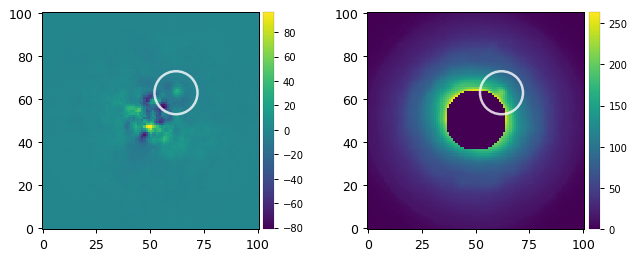

In [116]:
plots(frame, frame_sum, circle=(62,63), circlerad=10)

# Injecting a companion

The datacubes (image sequences) of the data challenge will contain None to five companions. Using the template PSF, we can inject a second point-source in the sequence: 

In [134]:
cubefc = vip.metrics.cube_inject_companions(cube, psf, pa, 70,  plsc, 36, 1, 230)

Branch 1:
	(X,Y)=(26.86, 22.42) at 0.98 arcsec (36.00 pxs)


# Post-processing, obtaning a detection map

Let's obtain final residual frames, usign two basic algorithms, and their corresponding detection maps:

In [159]:
# Median based model PSF subtraction (which implements a modified version of the baseline algorithm described before)

fr0 = vip.medsub.median_sub(cubefc, pa, mode='annular', fwhm=fwhm, delta_rot=1, radius_int=8)
snrmap0 = vip.metrics.snrmap(fr0, fwhm)

--------------------------------------------------------------------------------
Starting time: 2018-09-19 11:35:52
--------------------------------------------------------------------------------
N annuli = 10, FWHM = 4.795
Processing annuli:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.275175
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Starting time: 2018-09-19 11:35:52
--------------------------------------------------------------------------------
S/N map created using 2 processes.
Running time:  0:00:12.013316
--------------------------------------------------------------------------------


In [156]:
# PCA based model PSF subtraction

fr1 = vip.pca.pca(cubefc, pa, ncomp=10, mask_center_px=8)
snrmap1 = vip.metrics.snrmap(fr1, fwhm)

--------------------------------------------------------------------------------
Starting time: 2018-09-19 11:35:18
--------------------------------------------------------------------------------
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.074016
--------------------------------------------------------------------------------
Done de-rotating and combining
Running time:  0:00:00.121791
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Starting time: 2018-09-19 11:35:19
--------------------------------------------------------------------------------
S/N map created using 2 processes.
Running time:  0:00:11.691321
--------------------------------------------------------------------------------


The detection maps are just the result of computing the siganl-to-noise metric for each pixel of the image:

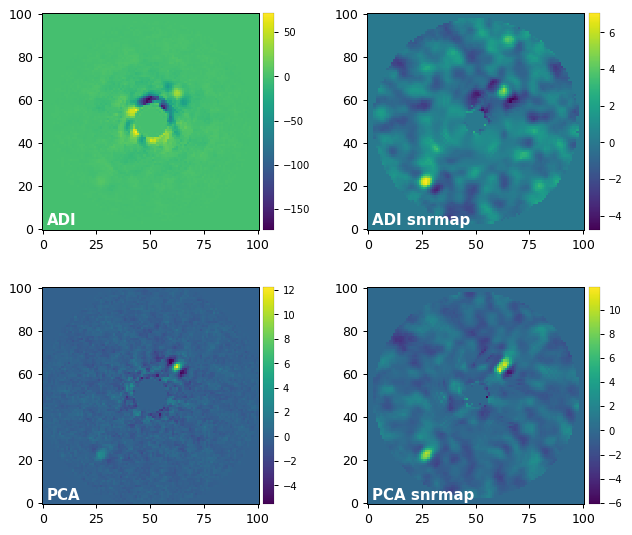

In [160]:
plots(fr0, snrmap0, fr1, snrmap1, rows=2, label=('ADI', 'ADI snrmap', 'PCA', 'PCA snrmap'), versp=0.02)

# Thresholding and blob counting 

Now we use the detection maps and the provided critical threshold to compute the number of true detections and the number of false positives:

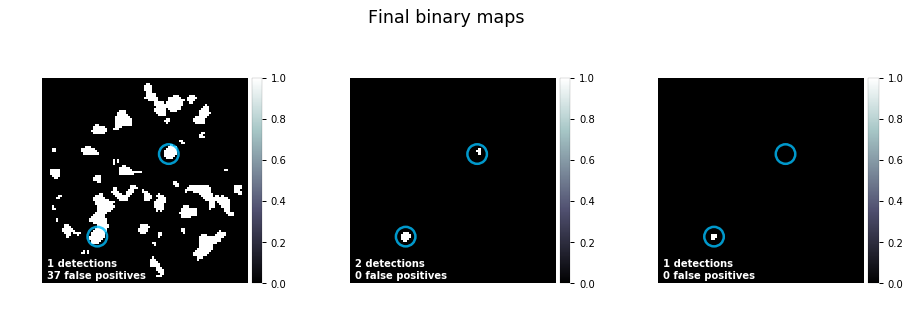

In [163]:
# For the median subtraction detection map

n_det0, n_fps0, binmaps0 = vip.metrics.compute_binary_map(snrmap0, thresholds=[1, 4, 6], injections=((26.86, 22.42), (62,63)), 
                                                          fwhm=fwhm, npix=2, overlap_threshold=0.7, max_blob_fact=2, 
                                                          debug=False, plot=True)

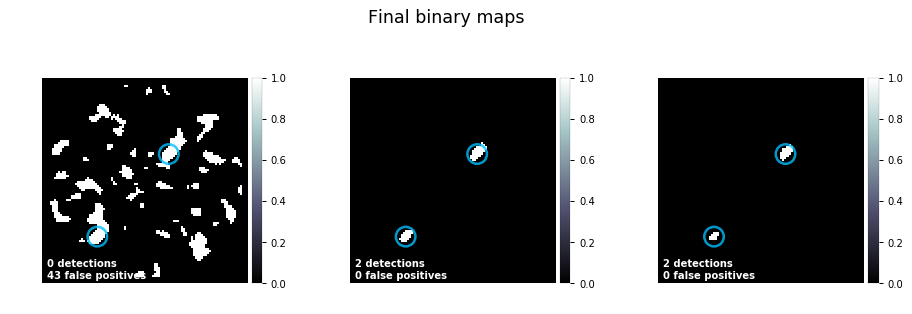

In [165]:
# For the PCA detection map

n_det1, n_fps1, binmaps1 = vip.metrics.compute_binary_map(snrmap1, thresholds=[1, 4, 6], injections=((26.86, 22.42), (62,63)), 
                                                          fwhm=fwhm, npix=2, overlap_threshold=0.7, max_blob_fact=2, 
                                                          debug=False, plot=True)

The blob counting procedure is composed of the following steps:
* Computing a segmentation map usign the ``detect_sources`` function from Photutils. It takes the detection map and returns a segmentation map with blobs above a given threshold value and larger than ``npix``. 
* We loop over the detected blobs and discard those larger than ``max_blob_fact * area_2FWHM_circap``, where ``area_2FWHM_circap`` is the area of a circular aperture with ``2 * FWHM`` diameter. These big blobs are split in several false positives, depending on how many ``2 * FWHM`` circular apertures they could contain. See the binary maps for the threshold = 1.
* If the blob is smaller than ``max_blob_fact * area_2FWHM_circap`` then we check if it overlaps any of the fake companions (whose coordinates are in ``injections``) by at least ``overlap_threshold * area_2FWHM_circap`` (this time the circular aperture is centered on the injection coordinates). In case the blob fullfills this condition it is counted as a true positive. If it didn't match any injection then is counted as a false positive.

We clearly see that, for a given algorithm and a given detection threshold, there is a trade-off between the number of true positives and that of false positives. Exploring that trade-off is the main goal of this data challenge. Ultimately, we'd like to find algorithms that maximize the true positive rate and at the same time keep a low count of false positives. 